## 處理旅程資訊

### 先照之前的，讀取資料

In [1]:
import tqdm
import tarfile
import pandas
from urllib.request import urlopen

# 檔案名稱格式
filename_format="M06A_{year:04d}{month:02d}{day:02d}.tar.gz".format
xz_filename_format="xz/M06A_{year:04d}{month:02d}{day:02d}.tar.xz".format
csv_format = "M06A/{year:04d}{month:02d}{day:02d}/{hour:02d}/TDCS_M06A_{year:04d}{month:02d}{day:02d}_{hour:02d}0000.csv".format

In [2]:
# 打開剛才下載的檔案試試
data_config ={"year":2016, "month":12, "day":18}
tar = tarfile.open(filename_format(**data_config), 'r')

In [3]:
# 如果沒有下載，可以試試看 xz 檔案
#data_dconfig ={"year":2016, "month":11, "day":18}
#tar = tarfile.open(xz_filename_format(**data_config), 'r')

In [4]:
# 設定欄位名稱
M06A_fields = ['VehicleType',
               'DetectionTime_O','GantryID_O',
               'DetectionTime_D','GantryID_D ',
               'TripLength', 'TripEnd', 'TripInformation']
# 打開裡面 10 點鐘的資料
csv = tar.extractfile(csv_format(hour=10, **data_config))

# 讀進資料
data = pandas.read_csv(csv, names=M06A_fields)

# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])

# 去除異常資料
data = data[data.TripEnd == 'Y']

# 只保留 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]

# 看前五筆
data.head(5)

異常資料數: 0


,VehicleType,TripInformation
0,31,2016-12-18 10:00:50+01F1045N; 2016-12-18 10:04...
1,31,2016-12-18 10:34:24+01F3525S; 2016-12-18 10:37...
2,31,2016-12-18 10:57:33+03F3854N; 2016-12-18 11:12...
3,31,2016-12-18 10:05:11+03F0525S; 2016-12-18 10:07...
4,31,2016-12-18 10:35:46+01F3185S; 2016-12-18 10:38...


### 時間的格式固定

In [5]:
import datetime
# 用來解析時間格式
def strptime(x):
    return datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

### 先用慢動作來解析看看格式

In [6]:
data.iloc[0].TripInformation

'2016-12-18 10:00:50+01F1045N; 2016-12-18 10:04:37+01F0979N; 2016-12-18 10:05:58+01F0956N; 2016-12-18 10:07:43+01F0928N; 2016-12-18 10:10:43+01F0880N; 2016-12-18 10:18:38+01F0750N; 2016-12-18 10:27:26+01H0608N; 2016-12-18 10:29:01+01F0584N'

In [7]:
# 切開鎖鏈
_.split("; ")

['2016-12-18 10:00:50+01F1045N',
 '2016-12-18 10:04:37+01F0979N',
 '2016-12-18 10:05:58+01F0956N',
 '2016-12-18 10:07:43+01F0928N',
 '2016-12-18 10:10:43+01F0880N',
 '2016-12-18 10:18:38+01F0750N',
 '2016-12-18 10:27:26+01H0608N',
 '2016-12-18 10:29:01+01F0584N']

In [8]:
# 切開加鎖
[x.split('+') for x in _]

[['2016-12-18 10:00:50', '01F1045N'],
 ['2016-12-18 10:04:37', '01F0979N'],
 ['2016-12-18 10:05:58', '01F0956N'],
 ['2016-12-18 10:07:43', '01F0928N'],
 ['2016-12-18 10:10:43', '01F0880N'],
 ['2016-12-18 10:18:38', '01F0750N'],
 ['2016-12-18 10:27:26', '01H0608N'],
 ['2016-12-18 10:29:01', '01F0584N']]

In [9]:
[(strptime(t), node) for t,node in _]

[(datetime.datetime(2016, 12, 18, 10, 0, 50), '01F1045N'),
 (datetime.datetime(2016, 12, 18, 10, 4, 37), '01F0979N'),
 (datetime.datetime(2016, 12, 18, 10, 5, 58), '01F0956N'),
 (datetime.datetime(2016, 12, 18, 10, 7, 43), '01F0928N'),
 (datetime.datetime(2016, 12, 18, 10, 10, 43), '01F0880N'),
 (datetime.datetime(2016, 12, 18, 10, 18, 38), '01F0750N'),
 (datetime.datetime(2016, 12, 18, 10, 27, 26), '01H0608N'),
 (datetime.datetime(2016, 12, 18, 10, 29, 1), '01F0584N')]

In [10]:
# 合在一起看看
for idx, row in data.head(10).iterrows():
    trip = row.TripInformation.split("; ")
    trip = (x.split('+') for x in trip)
    trip = [(strptime(t), node) for t,node in trip]
    print(trip)

[(datetime.datetime(2016, 12, 18, 10, 0, 50), '01F1045N'), (datetime.datetime(2016, 12, 18, 10, 4, 37), '01F0979N'), (datetime.datetime(2016, 12, 18, 10, 5, 58), '01F0956N'), (datetime.datetime(2016, 12, 18, 10, 7, 43), '01F0928N'), (datetime.datetime(2016, 12, 18, 10, 10, 43), '01F0880N'), (datetime.datetime(2016, 12, 18, 10, 18, 38), '01F0750N'), (datetime.datetime(2016, 12, 18, 10, 27, 26), '01H0608N'), (datetime.datetime(2016, 12, 18, 10, 29, 1), '01F0584N')]
[(datetime.datetime(2016, 12, 18, 10, 34, 24), '01F3525S'), (datetime.datetime(2016, 12, 18, 10, 37, 13), '01F3561S'), (datetime.datetime(2016, 12, 18, 10, 39, 21), '01F3590S'), (datetime.datetime(2016, 12, 18, 10, 42, 54), '01F3640S'), (datetime.datetime(2016, 12, 18, 10, 45, 26), '01F3676S'), (datetime.datetime(2016, 12, 18, 10, 46, 9), '01F3686S')]
[(datetime.datetime(2016, 12, 18, 10, 57, 33), '03F3854N'), (datetime.datetime(2016, 12, 18, 11, 12, 29), '01F3640S'), (datetime.datetime(2016, 12, 18, 11, 14, 45), '01F3676S'), 

In [11]:
def parse_tripinfo(tripinfo):
    split1 = tripinfo.split("; ")
    split2 = (x.split('+') for x in split1)
    return [(strptime(t), node) for t,node in split2]
data.head(10).TripInformation.apply(parse_tripinfo)

0    [(2016-12-18 10:00:50, 01F1045N), (2016-12-18 ...
1    [(2016-12-18 10:34:24, 01F3525S), (2016-12-18 ...
2    [(2016-12-18 10:57:33, 03F3854N), (2016-12-18 ...
3    [(2016-12-18 10:05:11, 03F0525S), (2016-12-18 ...
4    [(2016-12-18 10:35:46, 01F3185S), (2016-12-18 ...
5    [(2016-12-18 10:00:35, 03F3496N), (2016-12-18 ...
6    [(2016-12-18 10:00:21, 05F0287N), (2016-12-18 ...
7    [(2016-12-18 10:50:12, 01H0271N), (2016-12-18 ...
8    [(2016-12-18 10:09:36, 01F0339S), (2016-12-18 ...
9    [(2016-12-18 10:36:58, 01F3696N), (2016-12-18 ...
Name: TripInformation, dtype: object

In [12]:
# progress bar
tqdm.tqdm.pandas()

In [13]:
# 新增一欄
data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)

100%|██████████| 211247/211247 [00:11<00:00, 18723.99it/s]


## Q
把上面改成 tqdm.tqdm.pandas(tqdm.tqdm_notebook)?

## 偵測站

* 手冊附錄
* https://zh.wikipedia.org/wiki/%E9%AB%98%E9%80%9F%E5%85%AC%E8%B7%AF%E9%9B%BB%E5%AD%90%E6%94%B6%E8%B2%BB%E7%B3%BB%E7%B5%B1_(%E8%87%BA%E7%81%A3)#.E6.94.B6.E8.B2.BB.E9.96.80.E6.9E.B6
* 交流道服務區里程 http://www.freeway.gov.tw/Publish.aspx?cnid=1906
* 門架資訊 https://www.freeway.gov.tw/Upload/DownloadFiles/%e5%9c%8b%e9%81%93%e8%a8%88%e8%b2%bb%e9%96%80%e6%9e%b6%e5%ba%a7%e6%a8%99%e5%8f%8a%e9%87%8c%e7%a8%8b%e7%89%8c%e5%83%b9%e8%a1%a8104.09.04%e7%89%88.csv


In [42]:
node_data_url = "http://www.freeway.gov.tw/Upload/DownloadFiles/%e5%9c%8b%e9%81%93%e8%a8%88%e8%b2%bb%e9%96%80%e6%9e%b6%e5%ba%a7%e6%a8%99%e5%8f%8a%e9%87%8c%e7%a8%8b%e7%89%8c%e5%83%b9%e8%a1%a8104.09.04%e7%89%88.csv"
node_data = pandas.read_csv(urlopen(node_data_url), encoding='big5', header=1)
# 簡單清理資料
node_data = node_data[node_data["方向"].apply(lambda x:x in 'NS')]
node_data.head(10)

,方向,編號,收費區 設定里程,小車牌價,交流道(起),交流道(迄),Unnamed: 6,緯度(北緯),Unnamed: 8,經度(東經)
0,S,01F-000.5S,1.1,1.3,基隆端(基隆港),基隆(長庚醫院),N,25.11878611,E,121.7317639
1,S,01F-001.7S,1.2,1.4,基隆(長庚醫院),八堵,N,25.10956667,E,121.7259056
2,S,01F-002.9S,2.8,3.3,八堵,大華系統(連接台62),N,25.10311111,E,121.7173694
3,S,01F-006.1S,1.8,2.1,大華系統(連接台62),五堵,N,25.08839444,E,121.6934833
4,S,01F-009.9S,3.7,4.4,五堵,汐止&汐止系統(連接國3),N,25.07626389,E,121.6594778
5,S,01F-014.7S,3.7,4.4,汐止&汐止系統(連接國3),東湖,N,25.06564444,E,121.6135194
6,S,01F-015.5S,2.1,2.5,東湖,內湖(南京東、成功路),N,25.06475278,E,121.6059028
7,S,01F-018.2S,5.9,7,內湖(南京東、成功路),圓山(建國北路),N,25.06898611,E,121.5802306
8,S,01F-024.8S,2.1,2.5,圓山(建國北路),台北(重慶北、士林),N,25.07763056,E,121.5166028
9,S,01F-026.4S,2,2.4,台北(重慶北、士林),三重,N,25.07746389,E,121.5013861


## Q
查看一下內容，比方看國道五號
```python
node_data[node_data['編號'].str.startswith('05')]
```

## 畫圖看看

In [17]:
%matplotlib inline

In [18]:
node_data['經度(東經)'] = node_data['經度(東經)'].astype(float)
node_data['緯度(北緯)'] = node_data['緯度(北緯)'].astype(float)

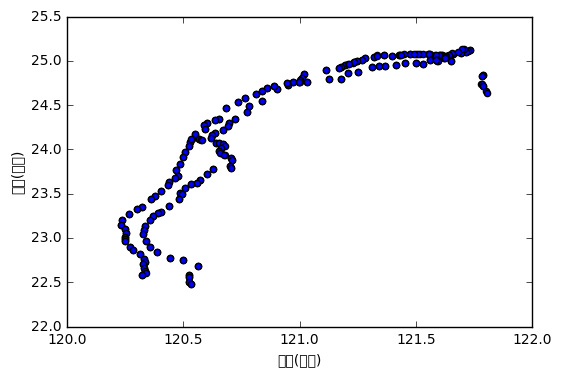

In [19]:
node_data.plot.scatter(x='經度(東經)', y='緯度(北緯)')

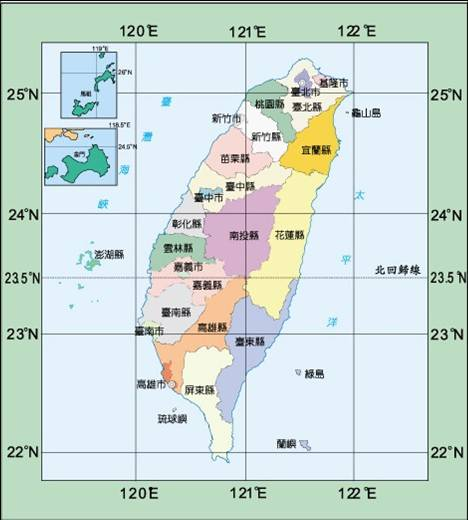

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# 網路上的台灣地圖，有經緯度
taiwan_img_url="http://gallery.mjes.ntpc.edu.tw/gallery2/main.php?g2_view=core.DownloadItem&g2_itemId=408&g2_serialNumber=1"
taiwan_img = Image.open(urlopen(taiwan_img_url))
taiwan_img

In [21]:
# 查看編號的前置碼
set(node_data['編號'].str[:3].tolist())

{'01F', '01H', '03A', '03F', '05F'}

In [23]:
# 依照路線編號
cfunc = {'01F':"green", '01H':"blue", '03A':"yellow", '03F':"red", '05F':"purple"}.get
colors = node_data['編號'].str[:3].apply(cfunc)

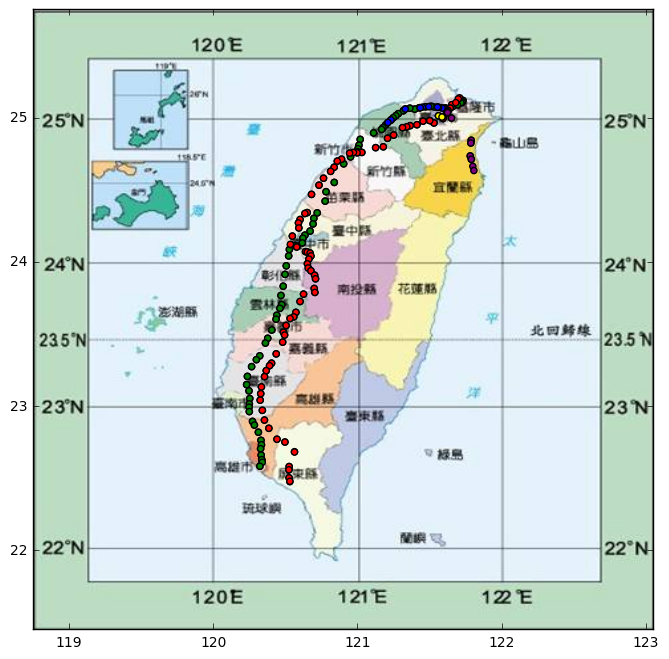

In [24]:
fig = plt.gcf()
fig.set_size_inches(8,8)
extent=[118.75,123.05,21.45,25.75]
plt.xlim(*extent[:2])
plt.ylim(*extent[2:])
plt.scatter(node_data['經度(東經)'], node_data['緯度(北緯)'], c=colors, alpha=1)
plt.imshow(np.array(taiwan_img), extent=extent);

## Q
試試看其他劃法，比方依照方向設定顏色
```python
colors = node_data.方向.apply({'S':'red', 'N':'blue'}.get).tolist()
```
或只畫國道一號、改變 mark。

In [27]:
node_data[node_data.編號=="03F-318.7S"]

,方向,編號,收費區 設定里程,小車牌價,交流道(起),交流道(迄),Unnamed: 6,緯度(北緯),Unnamed: 8,經度(東經)
228,S,03F-318.7S,8.1,9.7,白河,東山服務區,N,23.296692,E,120.404164


In [28]:
node_data[node_data.編號=="03F-321.1S"]

,方向,編號,收費區 設定里程,小車牌價,交流道(起),交流道(迄),Unnamed: 6,緯度(北緯),Unnamed: 8,經度(東經)
229,S,03F-321.1S,2.8,3.3,東山服務區,柳營,N,23.279281,E,120.390253


## Q
找找看還有哪些服務區?